In [39]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [40]:
os.makedirs("visualizations", exist_ok=True)
filename = "student_data.csv"

if os.path.exists(filename):
    df = pd.read_csv(filename)
    print(f"Loaded dataset '{filename}' with shape {df.shape}")
else:
    print(f"'{filename}' not found — generating synthetic demo dataset.")
    n = 350
    high = pd.DataFrame({
        "study_hours": np.random.normal(6.5, 0.8, int(n*0.35)),
        "assignments_completed": np.random.normal(9, 1.0, int(n*0.35)),
        "attendance_percent": np.random.normal(92, 4, int(n*0.35)),
        "previous_score": np.random.normal(78, 6, int(n*0.35)),
        "final_score": np.random.normal(85, 5, int(n*0.35))
    })
    med = pd.DataFrame({
        "study_hours": np.random.normal(3.5, 0.9, int(n*0.45)),
        "assignments_completed": np.random.normal(6, 1.2, int(n*0.45)),
        "attendance_percent": np.random.normal(80, 6, int(n*0.45)),
        "previous_score": np.random.normal(60, 8, int(n*0.45)),
        "final_score": np.random.normal(65, 7, int(n*0.45))
    })
    low = pd.DataFrame({
        "study_hours": np.random.normal(1.5, 0.6, int(n*0.2)),
        "assignments_completed": np.random.normal(2.5, 1.1, int(n*0.2)),
        "attendance_percent": np.random.normal(65, 8, int(n*0.2)),
        "previous_score": np.random.normal(40, 7, int(n*0.2)),
        "final_score": np.random.normal(45, 8, int(n*0.2))
    })
    df = pd.concat([high, med, low], ignore_index=True)

df = df.clip(lower=0)
print(df.head())

'student_data.csv' not found — generating synthetic demo dataset.
   study_hours  assignments_completed  attendance_percent  previous_score  \
0     6.897371              10.402794           87.198814       79.344555   
1     6.389389               7.598149           90.661995       78.075554   
2     7.018151               9.586857           90.100219       78.586057   
3     7.718424              11.190456           89.386683       73.361941   
4     6.312677               8.009464           99.061817       78.147061   

   final_score  
0    93.435708  
1    89.408199  
2    84.960137  
3    92.399721  
4    85.386842  


In [41]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
possible_id_cols = ["id", "student_id", "index"]
numeric_cols = [c for c in numeric_cols if c not in possible_id_cols]
print("Numeric columns:", numeric_cols)

X = df[numeric_cols].copy().fillna(df.median())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
df["pca_1"] = X_pca[:, 0]
df["pca_2"] = X_pca[:, 1]

print("Explained variance ratio:", pca.explained_variance_ratio_)

Numeric columns: ['study_hours', 'assignments_completed', 'attendance_percent', 'previous_score', 'final_score']
Explained variance ratio: [0.83535884 0.04962852]


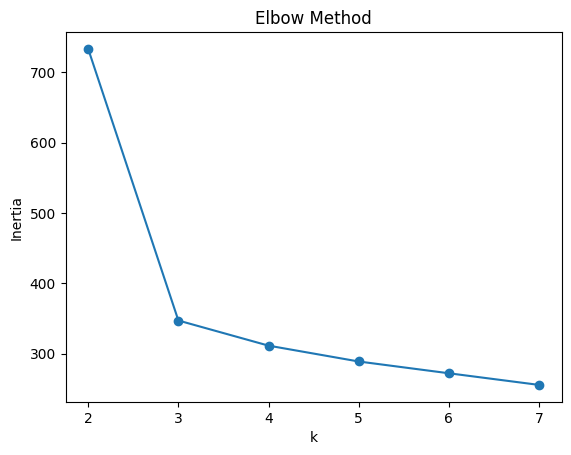

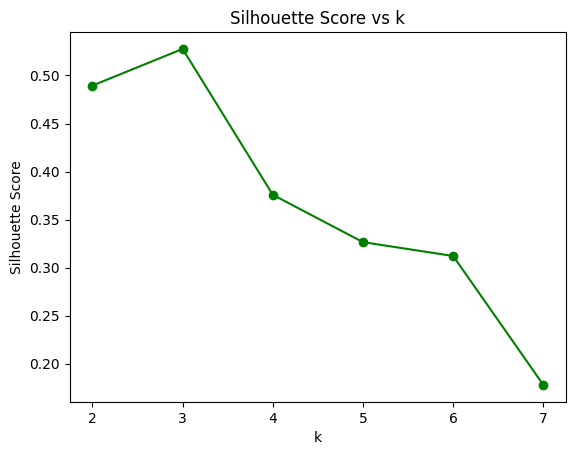

Best k (by silhouette): 3


In [42]:
inertia, sil_scores = [], []
K = range(2, 8)
for k in K:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))


plt.plot(K, inertia, "o-")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.savefig("visualizations/elbow_method.png", dpi=150)
plt.show()

plt.plot(K, sil_scores, "o-", color="green")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs k")
plt.savefig("visualizations/silhouette_scores.png", dpi=150)
plt.show()

best_k = K[np.argmax(sil_scores)]
print("Best k (by silhouette):", best_k)

kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=50)
df["kmeans_label"] = kmeans.fit_predict(X_scaled)

In [43]:
params = [(0.3,5), (0.5,5), (0.7,5), (0.9,5)]
for eps, ms in params:
    db = DBSCAN(eps=eps, min_samples=ms)
    labels = db.fit_predict(X_scaled)
    print(f"DBSCAN eps={eps}, min_samples={ms} -> clusters={len(set(labels))- (1 if -1 in labels else 0)}")

best_db = DBSCAN(eps=0.5, min_samples=5)
df["dbscan_label"] = best_db.fit_predict(X_scaled)
df["is_noise"] = df["dbscan_label"] == -1

DBSCAN eps=0.3, min_samples=5 -> clusters=0
DBSCAN eps=0.5, min_samples=5 -> clusters=5
DBSCAN eps=0.7, min_samples=5 -> clusters=4
DBSCAN eps=0.9, min_samples=5 -> clusters=2


              study_hours  assignments_completed  attendance_percent  \
kmeans_label                                                           
0                    1.62                   2.70               63.54   
1                    6.44                   9.08               92.11   
2                    3.47                   6.25               80.36   

              previous_score  final_score  count  
kmeans_label                                      
0                      41.40        46.19     70  
1                      77.92        84.69    122  
2                      60.99        64.90    157  


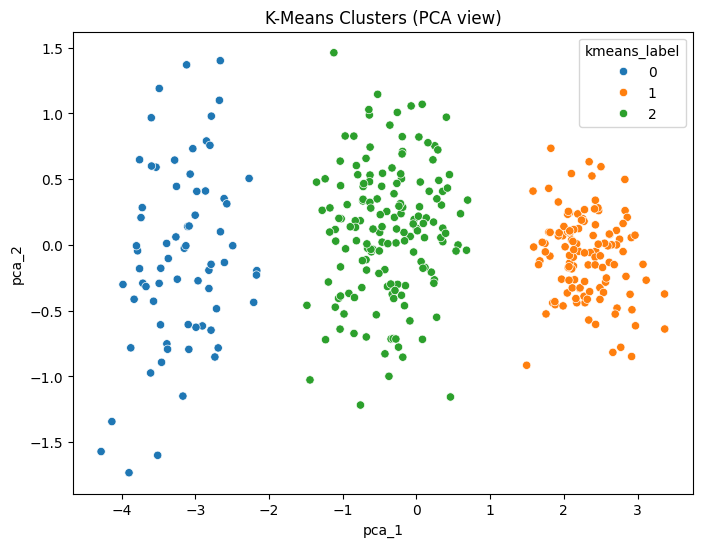

In [44]:
summary = df.groupby("kmeans_label")[numeric_cols].mean().round(2)
summary["count"] = df["kmeans_label"].value_counts().sort_index()
print(summary)

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="pca_1", y="pca_2", hue="kmeans_label", palette="tab10")
plt.title("K-Means Clusters (PCA view)")
plt.savefig("visualizations/cluster_scatter.png", dpi=150)
plt.show()

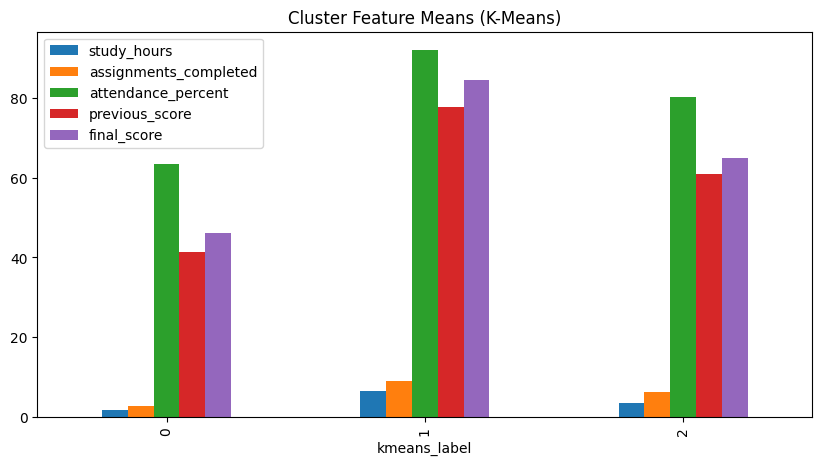

In [45]:
summary[numeric_cols].plot(kind="bar", figsize=(10,5))
plt.title("Cluster Feature Means (K-Means)")
plt.savefig("visualizations/cluster_profile_bar.png", dpi=150)
plt.show()

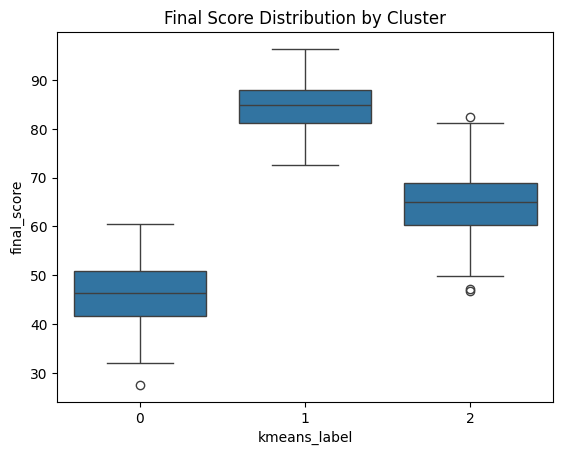

In [46]:
sns.boxplot(x="kmeans_label", y="final_score", data=df)
plt.title("Final Score Distribution by Cluster")
plt.savefig("visualizations/boxplot_final_score.png", dpi=150)
plt.show()

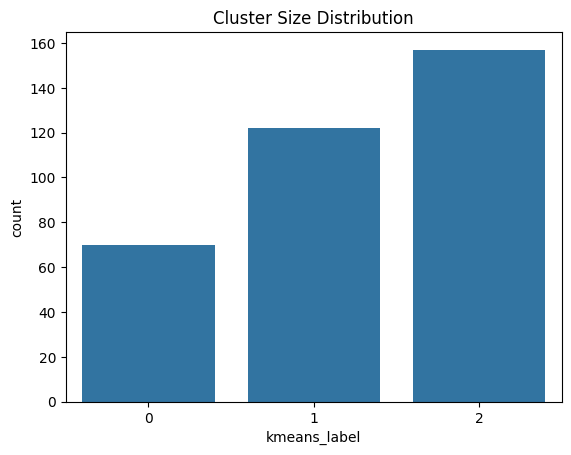

In [47]:
sns.countplot(x="kmeans_label", data=df)
plt.title("Cluster Size Distribution")
plt.savefig("visualizations/cluster_size_distribution.png", dpi=150)
plt.show()

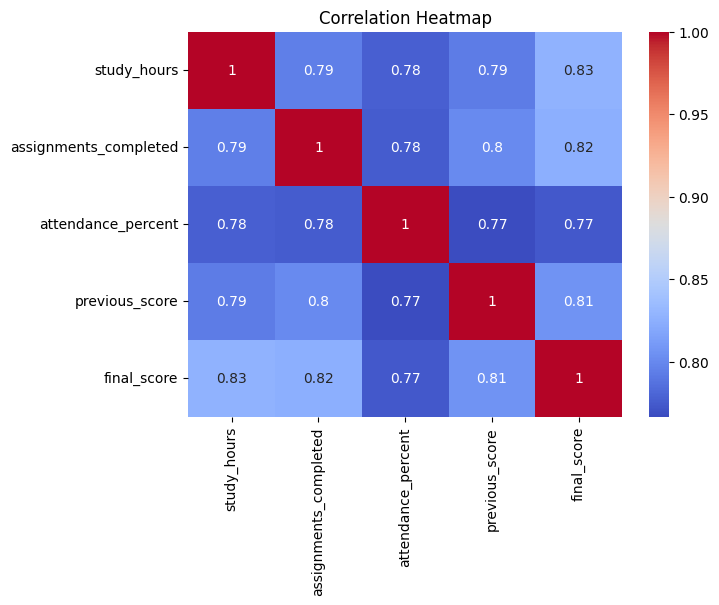

In [48]:
plt.figure(figsize=(7,5))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.savefig("visualizations/correlation_heatmap.png", dpi=150)
plt.show()

In [49]:
df.to_csv("clustered_student_data.csv", index=False)
summary.to_csv("cluster_summary.csv")

with open("report_summary.md", "w") as f:
    f.write("# Cluster Report\\n")
    f.write(summary.to_markdown() + "\\n")

print("\\n✅ All visualizations saved under /visualizations/")
print("✅ Clustered data saved as clustered_student_data.csv")
print("✅ Summary report saved as report_summary.md")


\n✅ All visualizations saved under /visualizations/
✅ Clustered data saved as clustered_student_data.csv
✅ Summary report saved as report_summary.md
